# *CoastSat*: Multi Beach Downloader


## 1. Initial settings

In [110]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
import geopandas as gpd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects
import helper
import ee
ee.Initialize(project='ee-rafarencoretg')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Retrieval of the images from GEE

Se crea un diccionario con la información de las playas de la región a descargar.

In [114]:
country_info = {
    "country": "CHILE",
    "country_code": "chi",
    "region": {
        "OHIGGINS": {
            "chi0345": {
                "name": "PLAYA_MATANZAS",
                "slope": 0.074
            },
            "chi0346": {
                "name": "PLAYA_PUPUYA",
                "slope": 0.076
            },
            "chi0356": {
                "name": "PLAYA_PUNTA_DE_LOBOS",
                "slope": 0.075
            }
        }
    }
}

Inicialización de los inputs del código, tales como fechas, región, códigos, pendientes y satélites. Se realiza un chequeo previo a la descarga.

In [115]:
# Sitio de estudio y su codigo
region_name = "OHIGGINS"
geojson_folder = 'CoastSat_Web'

# Rango de fechas
dates = ['2024-11-01', '2024-12-31']

# Satelites (misiones) ['L5','L7','L8','L9','S2']
sat_list = ['L8','L9','S2']

# Directorio de almacenamiento
filepath = os.path.join(os.getcwd(), 'data')

for beach in country_info["region"][region_name]:
    sitename = country_info["region"][region_name][beach]["name"]
    slope = country_info["region"][region_name][beach]["slope"]

    # Region de interes (longitud, latitud) en formato geojson
    geojson_polygon = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f"{beach}_polygon.geojson")
    polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

    # Diccionario con la información del sitio de estudio
    inputs = {'region': region_name, 'id': beach, 'sitename': sitename, 'slope': slope, 
              'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'filepath':filepath}

    # Chequeo de cantidad de imagenes disponibles
    print(f'\nIMAGENES DISPONIBLES EN {sitename}')
    SDS_download.check_images_available(inputs);


IMAGENES DISPONIBLES EN PLAYA_MATANZAS
Number of images available between 2024-11-01 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 12 images
     L9: 11 images
     S2: 22 images
  Total to download: 45 images
L8: 12/12 images already exist, 0 to be downloaded
L9: 11/11 images already exist, 0 to be downloaded
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 8 images
  Total Tier 2: 8 images

IMAGENES DISPONIBLES EN PLAYA_PUPUYA
Number of images available between 2024-11-01 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 12 images
     L9: 11 images
     S2: 22 images
  Total to download: 45 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 8 images
  Total Tier 2: 8 images

IMAGENES DISPONIBLES EN PLAYA_PUNTA_DE_LOBOS
Number of images available between 2024-11-01 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 8 images
     L9: 7 images
     S2: 33 images
  Total to download:

Luego del chequeo, se descargan las imágenes.

In [116]:
for beach in country_info["region"][region_name]:
    sitename = country_info["region"][region_name][beach]["name"]
    slope = country_info["region"][region_name][beach]["slope"]

    # Region de interes (longitud, latitud) en formato geojson
    geojson_polygon = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f"{beach}_polygon.geojson")
    polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

    # Diccionario con la información del sitio de estudio
    inputs = {'region': region_name, 'id': beach, 'sitename': sitename, 'slope': slope, 
              'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'filepath':filepath}

    # Descarga de imagenes
    print(f"\nDESCARGANDO IMAGENES EN {sitename}")
    metadata = SDS_download.retrieve_images(inputs)


DESCARGANDO IMAGENES EN PLAYA_MATANZAS
GEE initialized (existing token).
Number of images available between 2024-11-01 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 12 images
     L9: 11 images
     S2: 22 images
  Total to download: 45 images
L8: 12/12 images already exist, 0 to be downloaded
L9: 11/11 images already exist, 0 to be downloaded
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 8 images
  Total Tier 2: 8 images

L8: 0 images

L9: 0 images

S2: 22 images
100%
Satellite images downloaded from GEE and save in c:\Users\pedro\Documents\RAFA\CoastSat-RRG\data\PLAYA_MATANZAS

DESCARGANDO IMAGENES EN PLAYA_PUPUYA
GEE initialized (existing token).
Number of images available between 2024-11-01 and 2024-12-31:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     L8: 12 images
     L9: 11 images
     S2: 22 images
  Total to download: 45 images
- In Landsat Tier 2 (not suitable for time-series analysis):
     L8: 8 images
  Total Tier 2: 8 image

Finalmente, se construye la metadata de los sitios de estudio.

In [117]:
for beach in country_info["region"][region_name]:
    sitename = country_info["region"][region_name][beach]["name"]
    slope = country_info["region"][region_name][beach]["slope"]

    # Region de interes (longitud, latitud) en formato geojson
    geojson_polygon = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f"{beach}_polygon.geojson")
    polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

    # Diccionario con la información del sitio de estudio
    inputs = {'region': region_name, 'id': beach, 'sitename': sitename, 'slope': slope, 
              'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'filepath':filepath}
    
    # Grabado de metadata
    print(f'\nGRABADO DE METADATA DE {sitename} COMPLETADA')
    metadata = SDS_download.get_metadata(inputs)


GRABADO DE METADATA DE PLAYA_MATANZAS COMPLETADA

GRABADO DE METADATA DE PLAYA_PUPUYA COMPLETADA

GRABADO DE METADATA DE PLAYA_PUNTA_DE_LOBOS COMPLETADA


In [118]:
beaches = dict()

for beach in country_info["region"][region_name]:
    sitename = country_info["region"][region_name][beach]["name"]
    slope = country_info["region"][region_name][beach]["slope"]

    # Region de interes (longitud, latitud) en formato geojson
    geojson_polygon = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f"{beach}_polygon.geojson")
    polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

    # Diccionario con la información del sitio de estudio
    inputs = {'region': region_name, 'id': beach, 'sitename': sitename, 'slope': slope, 
              'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'filepath':filepath}
    
    # Grabado de metadata
    metadata = SDS_download.get_metadata(inputs)

    # Asegurarse de que beaches[beach] sea un diccionario
    if beach not in beaches:
        beaches[beach] = {}

    # Asignar valores al diccionario
    beaches[beach]['inputs'] = inputs
    beaches[beach]['metadata'] = metadata

    if beach in beaches:
        print(f'{sitename} agregado\n')

print('Diccionario generado correctamente')

PLAYA_MATANZAS agregado

PLAYA_PUPUYA agregado

PLAYA_PUNTA_DE_LOBOS agregado

Diccionario generado correctamente


## 3. Shoreline extraction

In [119]:
overall_settings = dict()


for beach in country_info["region"][region_name]:
    sitename = country_info["region"][region_name][beach]["name"]
    slope = country_info["region"][region_name][beach]["slope"]

    # Region de interes (longitud, latitud) en formato geojson
    geojson_polygon = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f"{beach}_polygon.geojson")
    polygon = SDS_tools.polygon_from_geojson(geojson_polygon)

    # Diccionario con la información del sitio de estudio
    inputs = {'region': region_name, 'id': beach, 'sitename': sitename, 'slope': slope, 
              'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'filepath':filepath}
    
    # Inicialización de metadata
    metadata = SDS_download.get_metadata(inputs)

    settings = {
        # general parameters:
        'cloud_thresh': 0.5,        # threshold on maximum cloud cover
        'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
        'output_epsg': 32718,       # epsg code of spatial reference system desired for the output #28356 #4326 #Codigo en cartesian coordinate system
        # quality control:
        'check_detection': False,    # if True, shows each shoreline detection to the user for validation
        'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
        'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
        # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
        'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
        'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
        'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
        'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
        'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
        's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
        
        # add the inputs defined previously
        'inputs': beaches[beach]["inputs"],
    }

    # Asegurarse de que beaches[beach] sea un diccionario
    if beach not in overall_settings:
        overall_settings[beach] = {}

    # Asignar valores al diccionario
    overall_settings[beach]['settings'] = settings

    if beach in overall_settings:
        print(f'{sitename} agregado\n')

print('Diccionario generado correctamente')

PLAYA_MATANZAS agregado

PLAYA_PUPUYA agregado

PLAYA_PUNTA_DE_LOBOS agregado

Diccionario generado correctamente


### Digitize a reference shoreline [HIGHLY RECOMMENDED]

In [121]:
%matplotlib qt
#settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
#settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline


for beach in overall_settings:
    sitename = country_info["region"][region_name][beach]["name"]
    print(f'\nCreando linea de costa de referencia para {sitename}')
    overall_settings[beach]["settings"]['reference_shoreline'] = SDS_preprocess.get_reference_sl(beaches[beach]["metadata"], overall_settings[beach]["settings"])
    overall_settings[beach]["settings"]['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline


Creando linea de costa de referencia para PLAYA_MATANZAS
Reference shoreline has been saved in c:\Users\pedro\Documents\RAFA\CoastSat-RRG\data\PLAYA_MATANZAS

Creando linea de costa de referencia para PLAYA_PUPUYA
Reference shoreline has been saved in c:\Users\pedro\Documents\RAFA\CoastSat-RRG\data\PLAYA_PUPUYA

Creando linea de costa de referencia para PLAYA_PUNTA_DE_LOBOS
Reference shoreline has been saved in c:\Users\pedro\Documents\RAFA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS


### Batch shoreline detection

In [122]:
%matplotlib qt

overall_output = dict()

for beach in overall_settings:
    sitename = country_info["region"][region_name][beach]["name"]
    print(f'Identificando linea de costa automatica para {sitename}')
    output = SDS_shoreline.extract_shorelines(beaches[beach]["metadata"], overall_settings[beach]["settings"])
    
    # Asegurarse de que beaches[beach] sea un diccionario
    if beach not in overall_output:
        overall_output[beach] = {}

    # Asignar valores al diccionario
    overall_output[beach]['output'] = output

    if beach in overall_output:
        print(f'Linea de costa para {sitename} detectada\n')

print('Diccionario generado correctamente')

Identificando linea de costa automatica para PLAYA_MATANZAS
Mapping shorelines:
L8:   100%
L9:   100%
S2:   100%
Linea de costa para PLAYA_MATANZAS detectada

Identificando linea de costa automatica para PLAYA_PUPUYA
Mapping shorelines:
L8:   100%
L9:   100%
S2:   100%
Linea de costa para PLAYA_PUPUYA detectada

Identificando linea de costa automatica para PLAYA_PUNTA_DE_LOBOS
Mapping shorelines:
L8:   100%
L9:   100%
S2:   3%Could not map shoreline for this image: 2024-11-08-14-52-21_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   12%Could not map shoreline for this image: 2024-11-13-14-52-19_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   30%Could not map shoreline for this image: 2024-11-23-14-52-25_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   39%Could not map shoreline for this image: 2024-11-28-14-52-22_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   48%Could not map shoreline for this image: 2024-12-03-14-52-24_S2_18HYH_PLAYA_PUNTA_DE_LOBOS_ms.tif
S2:   66%Could not map shoreline for this image: 

In [123]:
for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    overall_output[beach]['output'] = SDS_tools.remove_duplicates(overall_output[beach]['output']) # removes duplicates (images taken on the same date by the same satellite)
    overall_output[beach]['output'] = SDS_tools.remove_inaccurate_georef(overall_output[beach]['output'], 10) # remove inaccurate georeferencing (set threshold to 10 m)
    print(f'Eliminando duplicados en {sitename}\n')

13 duplicates
0 bad georef
Eliminando duplicados en PLAYA_MATANZAS

13 duplicates
0 bad georef
Eliminando duplicados en PLAYA_PUPUYA

9 duplicates
0 bad georef
Eliminando duplicados en PLAYA_PUNTA_DE_LOBOS



In [124]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry

for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    gdf = SDS_tools.output_to_gdf(overall_output[beach]['output'], geomtype)
    if gdf is None:
        raise Exception("output does not contain any mapped shorelines")
    gdf.crs = CRS(overall_settings[beach]["settings"]['output_epsg']) # set layer projection
    # save GEOJSON layer to file
    gdf.to_file(os.path.join(beaches[beach]["inputs"]['filepath'], beaches[beach]["inputs"]['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                    driver='GeoJSON', encoding='utf-8')
    print(f'Output points guardados en formato .geojson para {sitename}\n')

Output points guardados en formato .geojson para PLAYA_MATANZAS

Output points guardados en formato .geojson para PLAYA_PUPUYA

Output points guardados en formato .geojson para PLAYA_PUNTA_DE_LOBOS



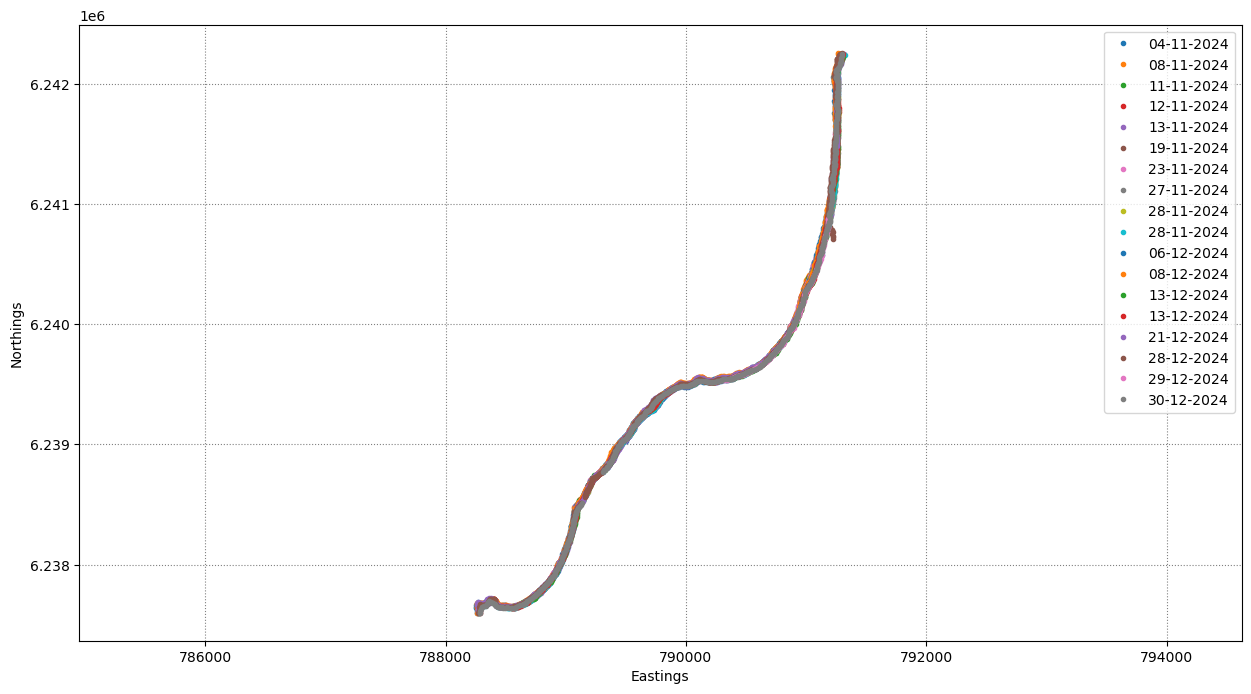

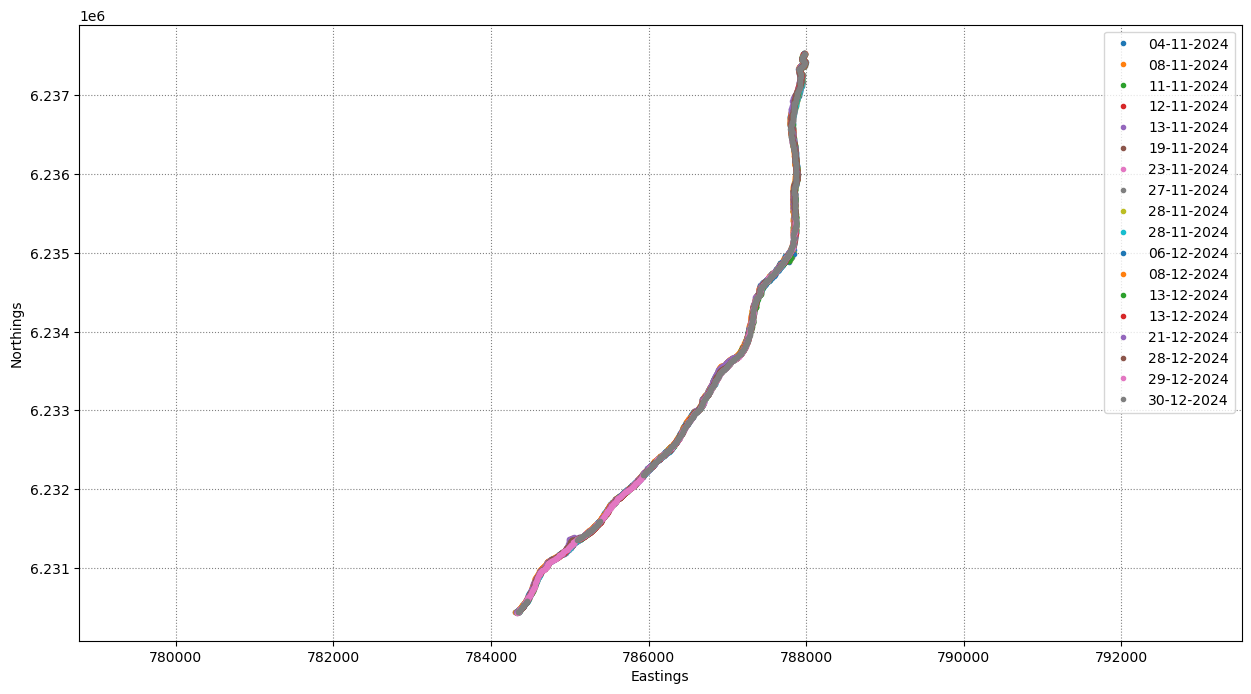

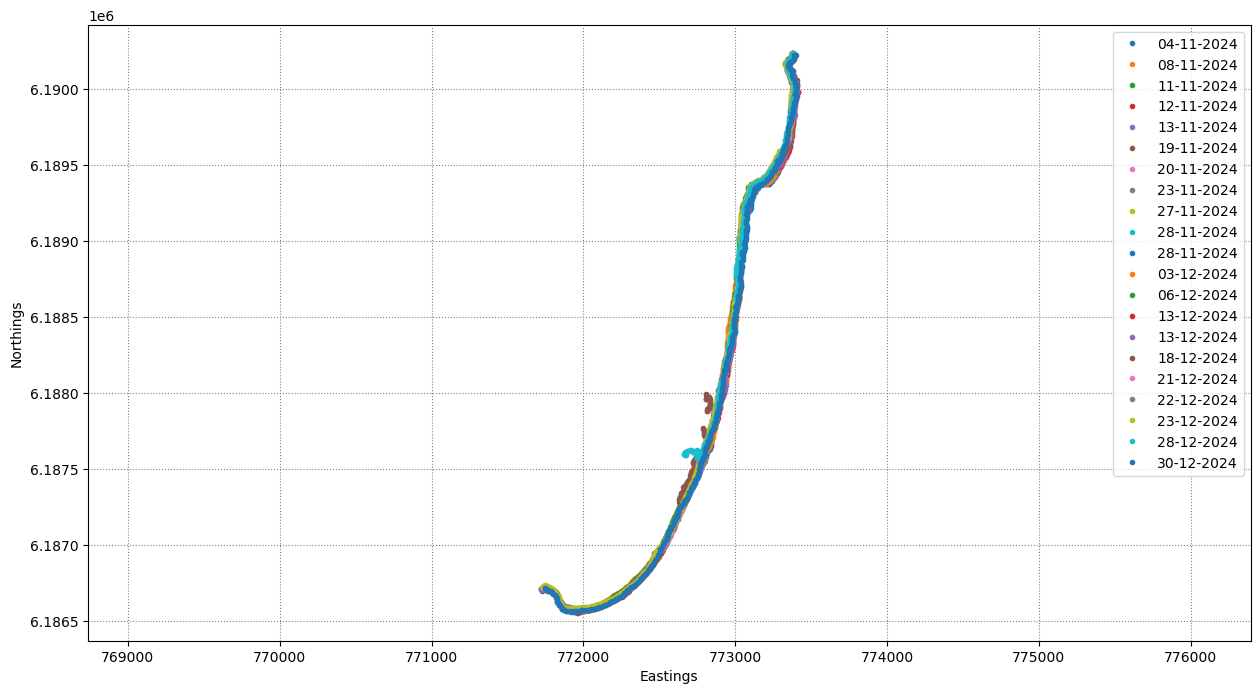

In [125]:
%matplotlib inline
for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    fig = plt.figure(figsize=[15,8])

    plt.axis('equal')
    plt.xlabel('Eastings')
    plt.ylabel('Northings')
    plt.grid(linestyle=':', color='0.5')
    for i in range(len(overall_output[beach]['output']['shorelines'])):
        sl = overall_output[beach]['output']['shorelines'][i]
        date = overall_output[beach]['output']['dates'][i]
        plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
    plt.legend();

## 4. Shoreline analysis

In [126]:
for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    filepath = os.path.join(beaches[beach]["inputs"]['filepath'], sitename)
    with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
        output = pickle.load(f)
    # remove duplicates (images taken on the same date by the same satellite)
    output = SDS_tools.remove_duplicates(overall_output[beach]['output'])
    # remove inaccurate georeferencing (set threshold to 10 m)
    output = SDS_tools.remove_inaccurate_georef(overall_output[beach]['output'], 10)
    print(f'Eliminando duplicados en {sitename}\n')


0 duplicates
0 bad georef
Eliminando duplicados en PLAYA_MATANZAS

0 duplicates
0 bad georef
Eliminando duplicados en PLAYA_PUPUYA

0 duplicates
0 bad georef
Eliminando duplicados en PLAYA_PUNTA_DE_LOBOS



In [127]:
overall_transects = dict()

for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    print(f'Cargando transectos para {sitename}')

    geojson_file_epsg_1 = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f'{beach}_transects.geojson')
    geojson_file_epsg_2 = os.path.join(os.getcwd(), geojson_folder, region_name, beach, f'{beach}_transects_transformed.geojson')
    helper.transform_geojson_epsg(geojson_file_epsg_1, geojson_file_epsg_2, overall_settings[beach]["settings"])

    
    gdf = gpd.read_file(geojson_file_epsg_2,driver='GeoJSON')
    transects = SDS_tools.transects_from_geojson(geojson_file_epsg_2)

    # Asegurarse de que beaches[beach] sea un diccionario
    if beach not in overall_transects:
        overall_transects[beach] = {}

    # Asignar valores al diccionario
    overall_transects[beach]['transects'] = transects

    if beach in overall_transects:
        print(f'Transectos cargados para {sitename}\n')

print('Diccionario generado correctamente')


Cargando transectos para PLAYA_MATANZAS
El EPSG actual del archivo es: 4326
Transformado al EPSG: 32718
Archivo GeoJSON transformado guardado en: c:\Users\pedro\Documents\RAFA\CoastSat-RRG\CoastSat_Web\OHIGGINS\chi0345\chi0345_transects_transformed.geojson
64 transects have been loaded coordinates are in epsg:32718
Transectos cargados para PLAYA_MATANZAS

Cargando transectos para PLAYA_PUPUYA
El EPSG actual del archivo es: 4326
Transformado al EPSG: 32718
Archivo GeoJSON transformado guardado en: c:\Users\pedro\Documents\RAFA\CoastSat-RRG\CoastSat_Web\OHIGGINS\chi0346\chi0346_transects_transformed.geojson
82 transects have been loaded coordinates are in epsg:32718
Transectos cargados para PLAYA_PUPUYA

Cargando transectos para PLAYA_PUNTA_DE_LOBOS
El EPSG actual del archivo es: 4326
Transformado al EPSG: 32718
Archivo GeoJSON transformado guardado en: c:\Users\pedro\Documents\RAFA\CoastSat-RRG\CoastSat_Web\OHIGGINS\chi0356\chi0356_transects_transformed.geojson
40 transects have been lo

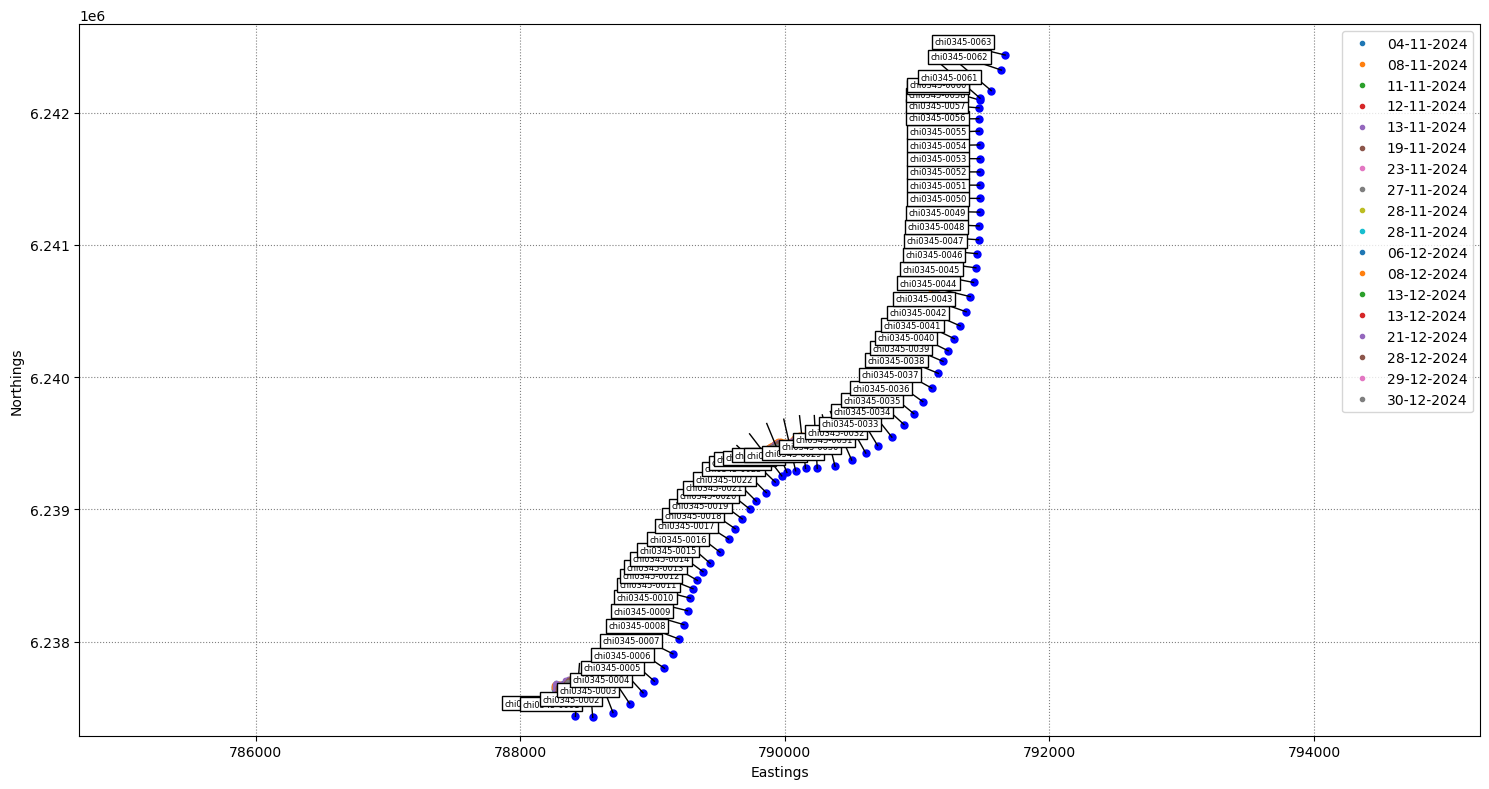

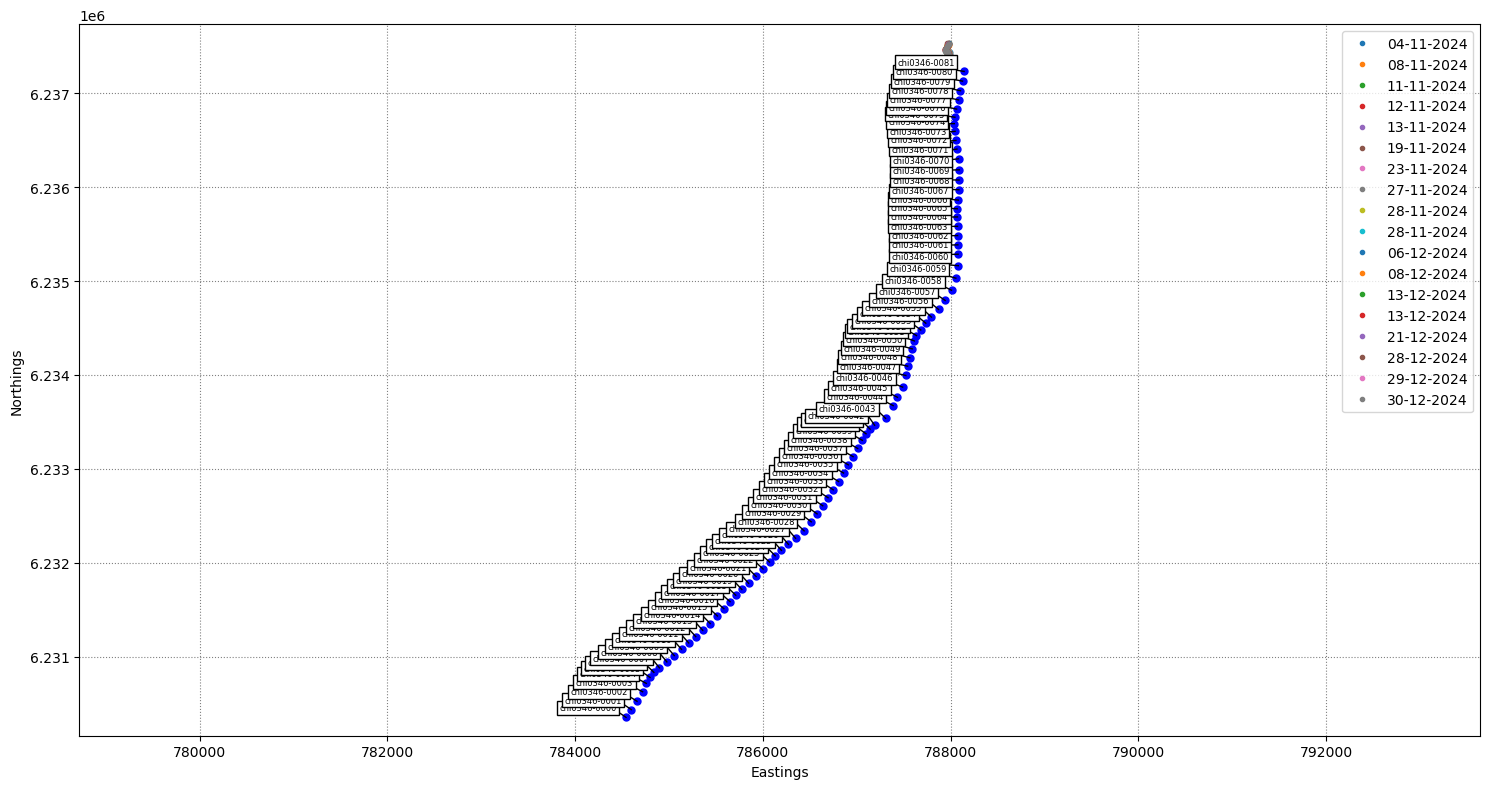

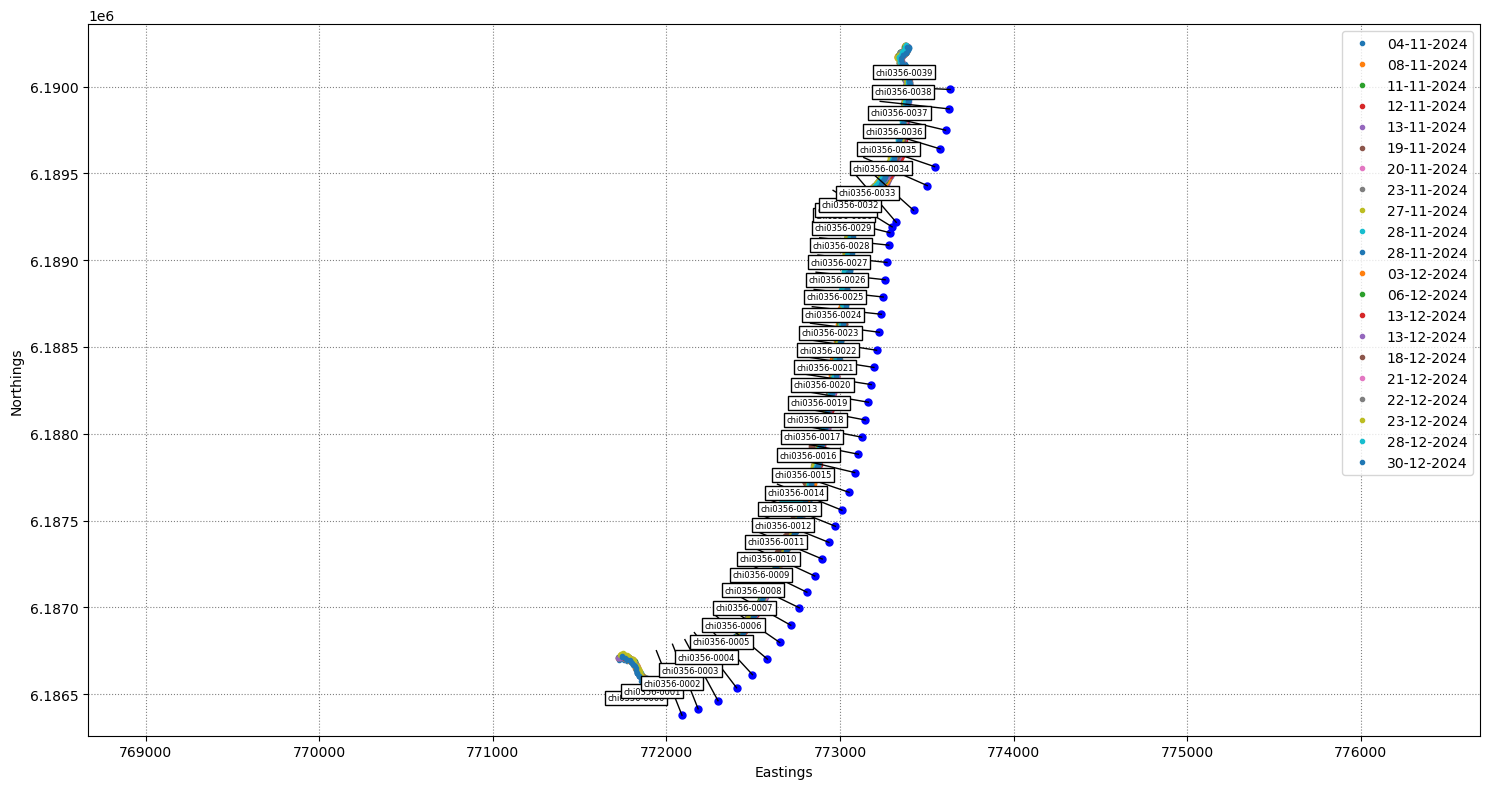

In [128]:
%matplotlib inline
for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    fig = plt.figure(figsize=[15,8], tight_layout=True)
    plt.axis('equal')
    plt.xlabel('Eastings')
    plt.ylabel('Northings')
    plt.grid(linestyle=':', color='0.5')

    for i in range(len(overall_output[beach]['output']['shorelines'])):
        sl = overall_output[beach]['output']['shorelines'][i]
        date = overall_output[beach]['output']['dates'][i]
        plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
    for i,key in enumerate(list(overall_transects[beach]['transects'].keys())): #for key in seccion:  
        plt.plot(overall_transects[beach]['transects'][key][0,0],overall_transects[beach]['transects'][key][0,1], 'bo', ms=5)
        plt.plot(overall_transects[beach]['transects'][key][:,0],overall_transects[beach]['transects'][key][:,1],'k-',lw=1)
        plt.text(overall_transects[beach]['transects'][key][0,0]-100, overall_transects[beach]['transects'][key][0,1]+100, key,
                    va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'), fontsize=6)
    plt.legend();
    

In [129]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }

overall_cross_distance = dict()
for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    cross_distance = SDS_transects.compute_intersection_QC(overall_output[beach]['output'], overall_transects[beach]['transects'], settings_transects) 

    # Asegurarse de que beaches[beach] sea un diccionario
    if beach not in overall_cross_distance:
        overall_cross_distance[beach] = {}

    # Asignar valores al diccionario
    overall_cross_distance[beach]['cross_distance'] = cross_distance

print('Diccionario generado correctamente')

Diccionario generado correctamente


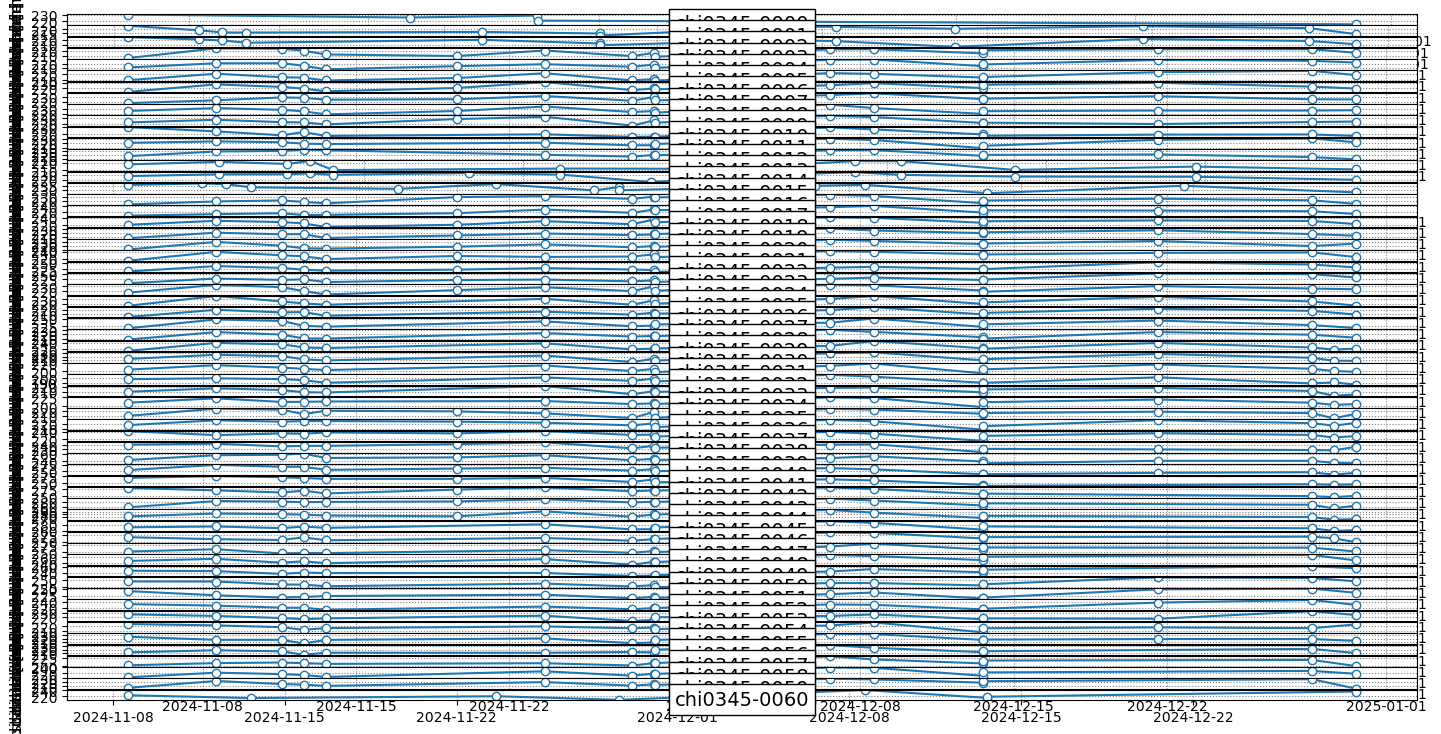

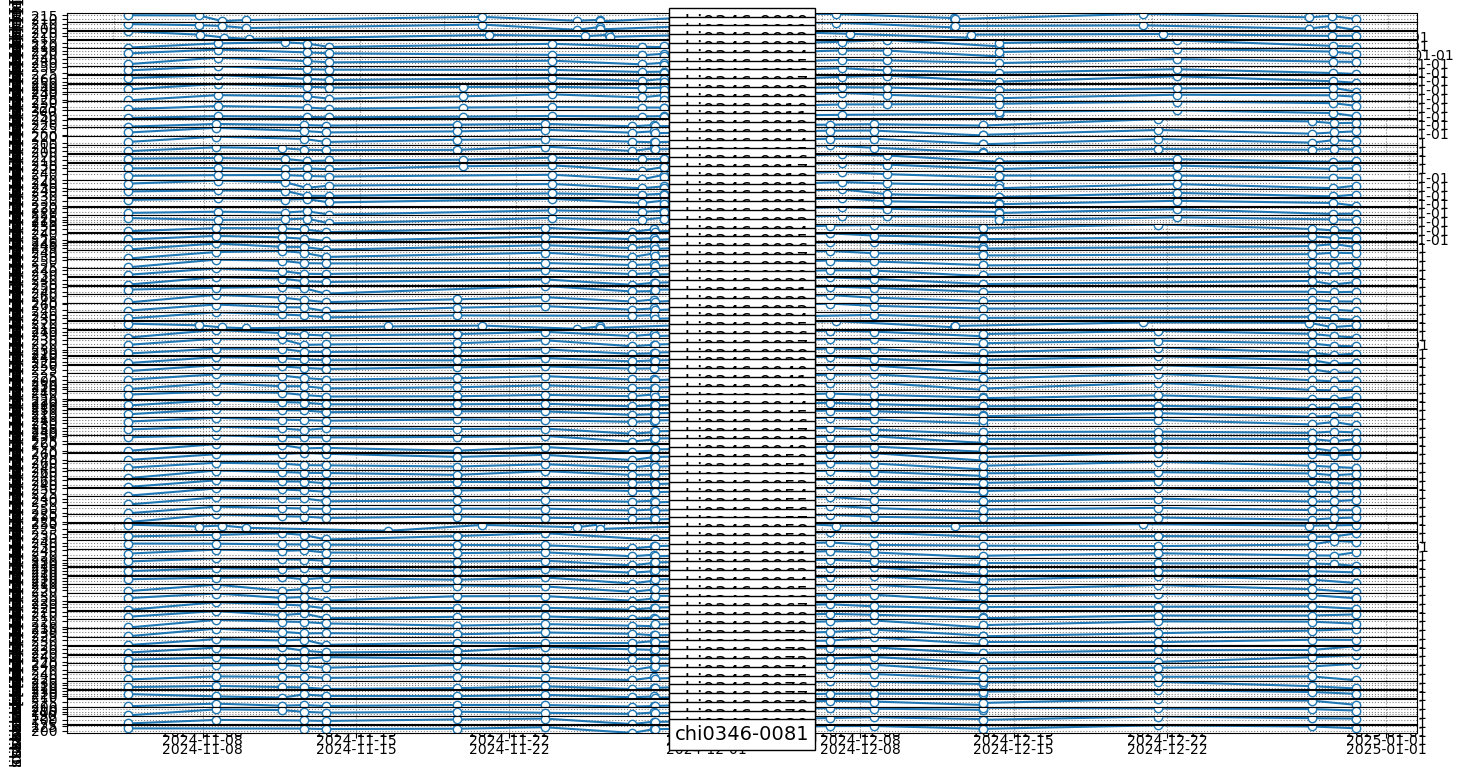

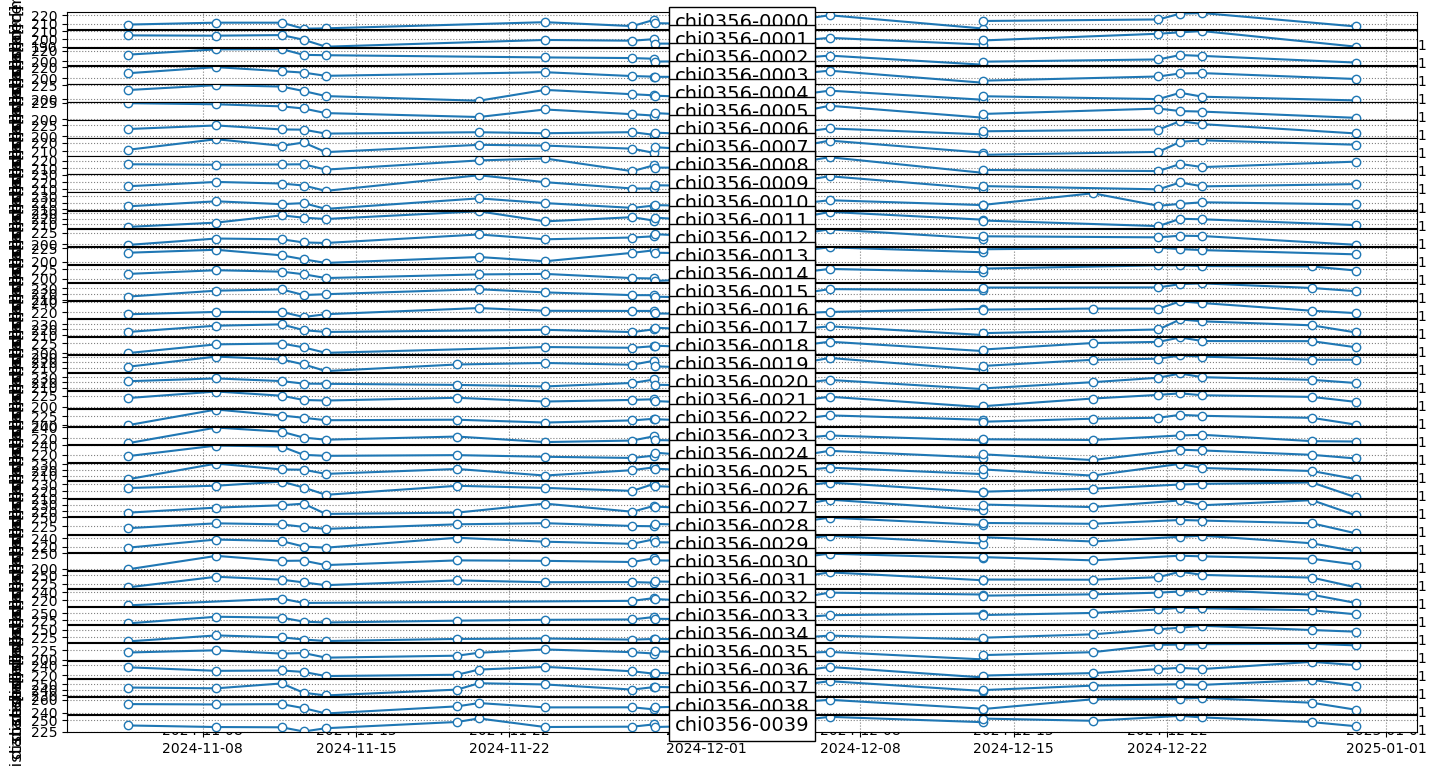

In [130]:
for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    fig = plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(len(overall_cross_distance[beach]['cross_distance']),1)
    gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
    for i,key in enumerate(overall_cross_distance[beach]['cross_distance'].keys()):
        if np.all(np.isnan(overall_cross_distance[beach]['cross_distance'][key])):
            continue
        idx_nan = np.isnan(overall_cross_distance[beach]['cross_distance'][key])
        dates = [overall_output[beach]["output"]['dates'][_] for _ in np.where(~idx_nan)[0]]
        chainage = overall_cross_distance[beach]['cross_distance'][key][~idx_nan]
        ax = fig.add_subplot(gs[i,0])
        ax.grid(linestyle=':', color='0.5')
        ax.plot(dates, chainage, '-o', ms=6, mfc='w')
        ax.set_ylabel('distance [m]', fontsize=12)
        ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
                va='top', transform=ax.transAxes, fontsize=14)
    fig.savefig(os.path.join(filepath,'%s_timeseries_raw.jpg'%sitename),dpi=200)

In [131]:
for beach in overall_output:
    sitename = country_info["region"][region_name][beach]["name"]
    # save a .csv file for Excel users
    out_dict = dict([])
    out_dict['dates'] = overall_output[beach]['output']['dates']
    for key in overall_transects[beach]['transects'].keys():
        out_dict[key] = overall_cross_distance[beach]['cross_distance'][key]
    df = pd.DataFrame(out_dict)
    fn = os.path.join(overall_settings[beach]['settings']['inputs']['filepath'],overall_settings[beach]['settings']['inputs']['sitename'],
                    'transect_time_series.csv')
    df.to_csv(fn, sep=',')
    print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
c:\Users\pedro\Documents\RAFA\CoastSat-RRG\data\PLAYA_MATANZAS\transect_time_series.csv
Time-series of the shoreline change along the transects saved as:
c:\Users\pedro\Documents\RAFA\CoastSat-RRG\data\PLAYA_PUPUYA\transect_time_series.csv
Time-series of the shoreline change along the transects saved as:
c:\Users\pedro\Documents\RAFA\CoastSat-RRG\data\PLAYA_PUNTA_DE_LOBOS\transect_time_series.csv
